The definition of a \emph{copula} is: a multivariate distribution $C(U_1, U_2, \ldots, U_n)$ such that marginalizing gives $U_i \approx$~Uniform(0,1). 
Despite this obscure and daunting sentence the concept is quite simple so let's try to clarify it a bit and at the end we will see what role copulas played in the 2008 financial crisis.

### Example Problem Case
Imagine we measure two variables that are non-normally distributed and correlated. For example, we look at various rivers and for every river we look at the maximum level of that river over a certain time-period. In addition, we also count how many months each river caused flooding. For the probability distribution of the maximum level of the river we know that maximums are \emph{Grumbel} distributed, while the number of flooding can be modelled according to a \emph{Beta} distribution.

Clearly it is pretty reasonable to assume that the maximum level and the number of floodings is going to be correlated, however we don't know how we could model that probability distribution. Above we only specified the distributions for individual variables, irrespective of the other one (i.e. the marginals), in reality we are dealing with a joint distribution of both of these together. 

And here is where copulas come to our rescue.

Copulas essentially allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together and thus allows us to specify the correlation separately. The copula is that coupling function.

Before going into them, we must first learn how we can transform arbitrary random variables to uniform and back.

### Distribution Transformation
The technique we are going to use to transform every random variables to uniform and viceversa is called \emph{probability integral transform}. We won't go into the details but we will just show few examples of how this can be done in \texttt{python} and we will use the \texttt{scipy.stats} module to do the job.

So first, we sample uniformly distributed values between 0 and 1:

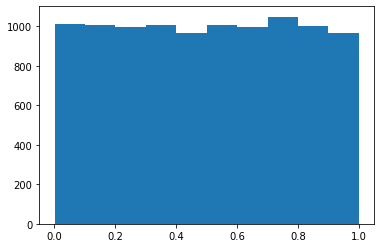

In [27]:
from scipy import stats
from matplotlib import pyplot as plt

x = stats.uniform(0, 1).rvs(10000)

plt.hist(x)
plt.show()

Next we want to transform these samples so that instead of uniform they are normally distributed. The transform that does this is the inverse of the cumulative density function (CDF) of the normal distribution which we can get in \texttt{scipy.stats} with \texttt{ppf}.

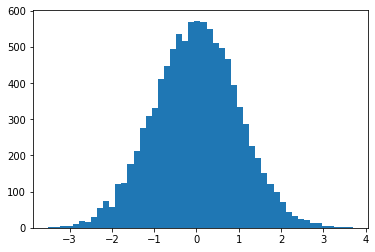

In [28]:
norm = stats.distributions.norm() # get the normal distribution definition
x_trans = norm.ppf(x)

plt.hist(x_trans, bins=50)
plt.show()

If we plot them togheter in a 2D plot we can get a sense of what is going on using the inverse CDF transformation:

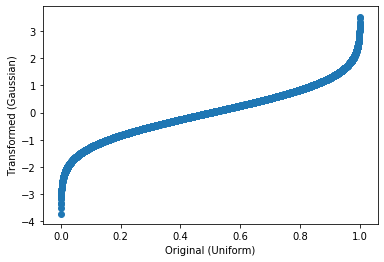

In [11]:
plt.scatter(x, x_trans)
plt.xlabel("Original (Uniform)")
plt.ylabel("Transformed (Gaussian)")
plt.show()

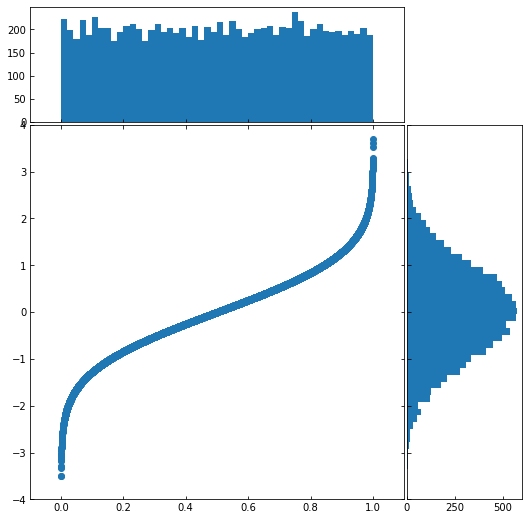

In [29]:
import numpy as np

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x, bins=50)
ax_histy.hist(x_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

The inverse CDF stretches the outer regions of the uniform to yield a normal distribution. The nice thing of the technique is that it can be done for any arbitrary (univariate) probability distributions, like Beta or Gumbel:

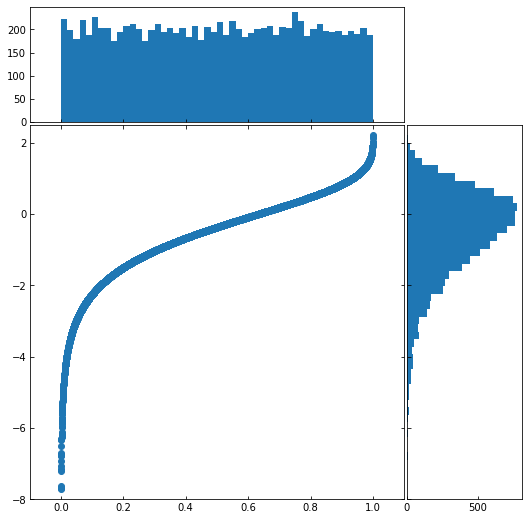

In [30]:
gumbel = stats.distributions.gumbel_l()
x_trans = gumbel.ppf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-8, 2.5))

ax_histx.hist(x, bins=50)
ax_histy.hist(x_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Clearly to do the opposite transformation from an arbitray distribution to the uniform(0, 1) we can just apply the inverse of the inverse CDF, the CDF itself...

## Adding Correlation with Gaussian Copulas

How does this help us with our problem of creating a custom joint probability distriution ? We are actually almost done already, we know how to convert anything uniformly distributed to an arbitrary probability distribution. So that means we need to generate uniformly distributed data with the correlation we want. How do we do that ? We simulate from a multivariarte Gaussian with the specific corrrelation structure, transform so that the marginals are uniform, and then transform the uniform marginals to whatever we like.

Generate random samples from multivariate normal with correlation .5:

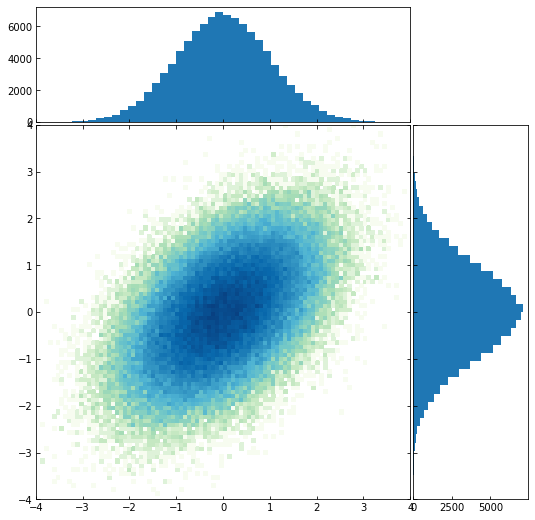

In [59]:
# this import is for plotting
from matplotlib import colors

mvnorm = stats.multivariate_normal(mean=[0, 0] , cov=[[1, 0.5],
                                                      [0.5, 1]])
x = mvnorm.rvs(100000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x[:, 0], x[:, 1], bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-4, 4))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x[:, 0], bins=50)
ax_histy.hist(x[:, 1], bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Now use what we have just seen to \emph{uniformify} the marginals:

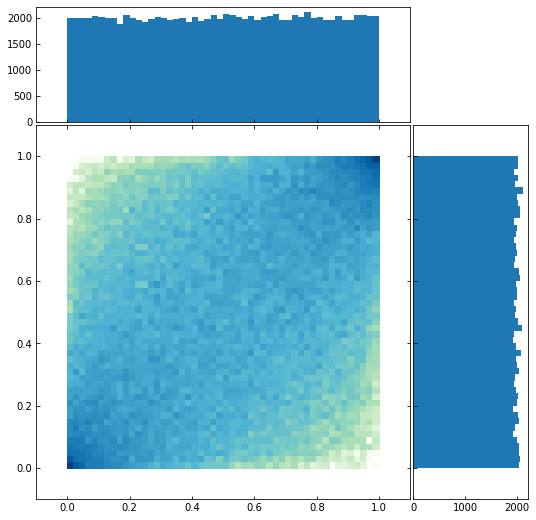

In [58]:
norm = stats.norm()
x_unif = norm.cdf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x_unif[:, 0], x_unif[:, 1], bins=50, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-0.1, 1.1))

ax_histx.hist(x_unif[:, 0], bins=50)
ax_histy.hist(x_unif[:, 1], bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

This scatter plot above is usually how copulas are visualized.
Finally we can just tranform the marginals again from uniform to what we want (Gumbel and Beta): 

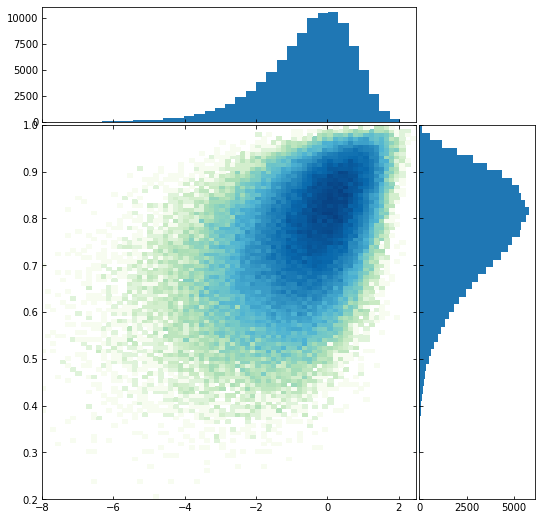

In [56]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=3)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1_trans, x2_trans, bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1_trans, bins=50)
ax_histy.hist(x2_trans, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

It is now interesting to compare with the joint distribution without correlations:

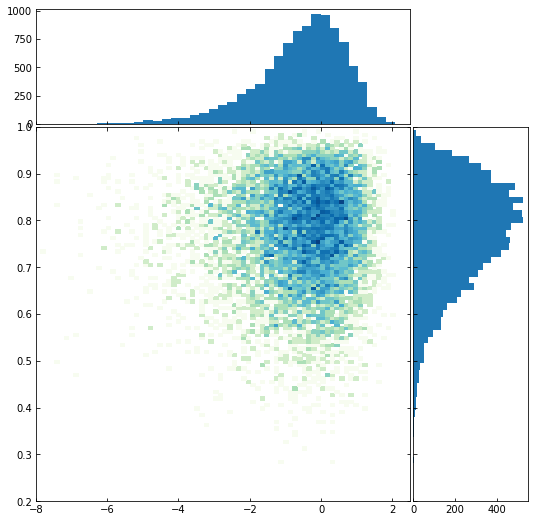

In [55]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1, x2, bins=100, norm=colors.LogNorm(), cmap="GnBu")

ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1, bins=50)
ax_histy.hist(x2, bins=50, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Using the uniform distribution as a common base for our transformations we can easily introduce correlations and flexibly construct complex probability distributions. Clearly this is directly extendeable to higher dimensional distributions as well.

## Complex Correlation Structures and the Financial Crisis

In the example above we have used the multivariate normal which gave rise to the Gaussian copula.However, we can use other and more complex copulas as well. For example we might want to assume the correlation is non-symmetruc which is useful in quant finance where correlations become very strong during market crashes and returns very negative.

Infact, Gaussian copulas are said to have played a key role in the 2008 financial crisis as tail-correlations were severely underestimated. Consider a set of mortgages in CDOs (a particular kind of contract that we are going to see) they are clearly correlated, if one mortgage fails, the likelihood that another failing is increased. In the early 2000s, the banks only knew how to model the marginals of the default rates. An (in)famous paper by Li then suggested to use copulas to model the correlations between those marginals. Rating agencies relied on thid model so heaviy, severely underestimating risk and giving false ratings...

If you are interested in the argument read \href{http://timmurphy.org/2009/07/22/line-spacing-in-latex-documents/}{this paper} for an excellent description of Gaussian copulas and the Financial Crisis which argues that different copula choices would not have made a difference but instead the assumed correlation was way too low.

In [1]:
import scipy.stats.distributions as dist
help(dist)


Help on module scipy.stats.distributions in scipy.stats:

NAME
    scipy.stats.distributions

DESCRIPTION
    # Author:  Travis Oliphant  2002-2011 with contributions from
    #          SciPy Developers 2004-2011
    #
    # NOTE: To look at history using `git blame`, use `git blame -M -C -C`
    #       instead of `git blame -Lxxx,+x`.
    #

CLASSES
    scipy.stats._distn_infrastructure.rv_generic(builtins.object)
        scipy.stats._distn_infrastructure.rv_continuous
            scipy.stats._continuous_distns.rv_histogram
        scipy.stats._distn_infrastructure.rv_discrete
    
    class rv_continuous(rv_generic)
     |  A generic continuous random variable class meant for subclassing.
     |  
     |  `rv_continuous` is a base class to construct specific distribution classes
     |  and instances for continuous random variables. It cannot be used
     |  directly as a distribution.
     |  
     |  Parameters
     |  ----------
     |  momtype : int, optional
     |      The ty